In [ ]:
## EDA

In [37]:
from tqdm import tqdm
import pandas as pd
import json
import string
import nltk
from nltk.corpus import stopwords
from  nltk import FreqDist
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools

In [16]:
data = [json.loads(line) for line in open('reviews_Electronics_5.json', 'r')]

In [17]:
df = pd.DataFrame(data)

In [18]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0528881469,"[0, 0]",5.0,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200
1,0528881469,"[12, 15]",1.0,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200
2,0528881469,"[43, 45]",3.0,"Well, what can I say. I've had this unit in m...","09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400
3,0528881469,"[9, 10]",2.0,"Not going to write a long review, even thought...","11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800
4,0528881469,"[0, 0]",1.0,I've had mine for a year and here's what we go...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400


In [19]:
df.isna().sum()

asin                  0
helpful               0
overall               0
reviewText            0
reviewTime            0
reviewerID            0
reviewerName      24730
summary               0
unixReviewTime        0
dtype: int64

In [8]:
df.shape

(1689188, 9)

In [9]:
df['overall'].value_counts()

5.0    1009026
4.0     347041
3.0     142257
1.0     108725
2.0      82139
Name: overall, dtype: int64

In [10]:
# drop reviews to reduce class imabalance and reduce size of data
remove_n_5 = 900000
remove_n_4 = 247000
remove_n_3 = 40000

just5 = df.loc[df['overall'] == 5]
just4 = df.loc[df['overall'] == 4]
just3 = df.loc[df['overall'] == 3]

drop_indices_5 = np.random.choice(just5.index, remove_n_5, replace=False)
drop_indices_4 = np.random.choice(just4.index, remove_n_4, replace=False)
drop_indices_3 = np.random.choice(just3.index, remove_n_3, replace=False)

df_final = df.drop(drop_indices_5)
df_final = df_final.drop(drop_indices_4)
df_final = df_final.drop(drop_indices_3)

In [11]:
df_final['overall'].value_counts()

5.0    109026
1.0    108725
3.0    102257
4.0    100041
2.0     82139
Name: overall, dtype: int64

In [12]:
df_final.reset_index(drop=True,inplace=True)

In [13]:
df_text = df_final[['asin','reviewText','overall','reviewerID']]

In [14]:
df_text['asin_reviewer'] = df_text['asin'].astype(str)+ '_' + df_text['reviewerID'].astype(str)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
df_text.drop(columns=['asin','reviewerID'],axis=1,inplace=True)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
df_text['review_length'] = df_text['reviewText'].apply(len)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
g = sns.FacetGrid(data=df_text, col='overall')
g.map(plt.hist, 'review_length', bins=30)
g.set(xlim=(0,10000))

In [ ]:
sns.boxplot(x='overall', y='review_length', data=df_text)

# NLP

In [17]:
# expand list of stopwords
new_stopwords = [x.replace("'","") for x in stopwords.words('english')]
final_stopwords = set(new_stopwords+stopwords.words('english')+list(string.punctuation))

In [18]:
## cleaning text
def clean_review(review):
    clean = []
    joined_clean_review = ''
    for x in review:
        if x in string.punctuation:
            x = x.replace(x, " ")
        elif x not in string.punctuation:
            x = x.lower()
        clean.append(x)    
        joined_clean_review = "".join(clean)

    return joined_clean_review

In [19]:
def get_tokens(clean_review):
    #  tokenize & remove stop words
    list_of_tokens = [x for x in word_tokenize(clean_review) if x not in final_stopwords]
    
    # return list of text from each review
    return list_of_tokens

In [24]:
# function to get lemmas

lemmatizer = WordNetLemmatizer()
def lem_words(list_of_tokens,lemmatizer):
    wrd_list = [lemmatizer.lemmatize(word) for word in list_of_tokens]
    return " ".join(wrd_list)

In [21]:
def finalize_token(reviews):
    corpus = []
    for review in tqdm(reviews):
        clean = clean_review(review)
        tokens = get_tokens(clean)
        lemmas = lem_words(tokens,lemmatizer)
        corpus.append(lemmas)
    return corpus

In [22]:
# take out review text from dataframe and make it a series?
reviews = df_text['reviewText']

In [25]:
corpus = finalize_token(reviews)

100%|██████████| 502188/502188 [1:03:21<00:00, 132.09it/s]


In [23]:
# put list of strings in its own df
df_corpus = pd.DataFrame(corpus, columns=['reviews'])

NameError: name 'corpus' is not defined

In [ ]:
# save file!!!!!!!!!!!

In [28]:
# merge cleaned up reviews back into df
df_reviews_final = pd.concat([df_text,df_corpus],axis=1)

In [34]:
df_reviews_final.to_csv('final_df.csv',index=None,header=True)

In [2]:
df_reviews_final = pd.read_csv('final_df.csv')

In [3]:
df_reviews_final.dropna(inplace=True)

In [4]:
from sklearn.model_selection import train_test_split
X = df_reviews_final[['reviews','asin_reviewer','review_length']]
y = df_reviews_final['overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [5]:
tfidf = TfidfVectorizer(max_features=7500, token_pattern = '(?ui)\\b\\w*[a-z]+\\w*\\b', analyzer='word')
tfidf_words = tfidf.fit_transform(X_train['reviews'])
vector_df = pd.DataFrame(tfidf_words.toarray(), columns=tfidf.get_feature_names())

In [6]:
vector_df.shape

(376371, 7500)

In [21]:
vector_df.head()

,100mb,100mbps,100mm,105mm,1080i,1080p,10ft,10mb,10th,10x,...,zippered,zone,zoom,zoomed,zooming,zs3,zs7,zune,zvox,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.087822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
## convert test data into vectors as well

In [26]:
tfidf_test = tfidf.transform(X_test['reviews'])

In [27]:
X_test

,reviews,asin_reviewer,review_length
257693,needed sim ipad bought ebay walked store asked...,B003YTSXYO_A2DASK6NCQHW6D,158
452889,hard complain unit work price make serious dea...,B00ABGL1XI_A2BCQPHAA91TT3,177
454685,read negative review placed order cable came m...,B00AJ0TDPO_A2QHG3BHZ7C9GB,217
213474,love hard drive great capacity compact size fi...,B0034ZD5P0_A1KHR4U5VKLKGD,128
435421,fit fine unfortunately got lint stuck undernea...,B0098OCKDE_AYRS87PMQYEDR,145
252430,barely pick better regular laptop antenna pick...,B003VYH1UE_A24P4E3RJ6AX94,114
406199,case worked described week ago noticed plastic...,B0082YEH8M_A3KY7JARWLBSSJ,490
172382,bought use bike ride run attach rc copter aria...,B0029631VI_A19N3S7CBSU6O7,475
359787,keyboard great quality easy connect far batter...,B005Y1CYSQ_A3Q95L2FPFBUGH,366
457522,work great nook hd like mini laptop charge fas...,B00AV1UWWY_A16DKRH6B46KJW,128


In [28]:
vector_df_test = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

In [29]:
vector_df_test

,100mb,100mbps,100mm,105mm,1080i,1080p,10ft,10mb,10th,10x,...,zippered,zone,zoom,zoomed,zooming,zs3,zs7,zune,zvox,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


## Feature engineering

In [ ]:
# lenght of review
# number of !'s
# number of 

## Classification

In [ ]:
# dummy classifier to start

In [7]:
from sklearn.dummy import DummyClassifier

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [44]:
dum_clf = DummyClassifier()
dum_model = dum_clf.fit(vector_df,y_train)
y_hat_test = dum_model.predict(vector_df_test)

In [45]:
print(accuracy_score(y_hat_test,y_test))

0.20107287755964195


In [41]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB_model = NB.fit(vector_df, y_train)

In [30]:
y_hat_test_NB = NB.predict(vector_df_test)

In [31]:
print(accuracy_score(y_hat_test_NB,y_test))

0.4680727261133297


Normalized confusion matrix
[[0.73395544 0.04695338 0.14598702 0.01814695 0.05495721]
 [0.41744069 0.07550893 0.35752442 0.06342942 0.08609654]
 [0.21782918 0.03056769 0.41984342 0.18226523 0.14949447]
 [0.10908797 0.01081998 0.20957649 0.33893173 0.33158383]
 [0.09193513 0.00456571 0.07889546 0.16027467 0.66432902]]


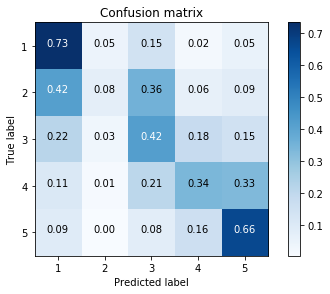

In [40]:
cnf_matrix = confusion_matrix(y_test, y_hat_test_NB)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5],normalize=True,
                      title='Confusion matrix')
plt.show()

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion')

In [46]:
logreg = LogisticRegression(fit_intercept = False, solver='liblinear')
model_log = logreg.fit(vector_df, y_train)
model_log

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
y_hat_test_log = model_log.predict(vector_df_test)

In [49]:
print(accuracy_score(y_hat_test_log,y_test))

0.5108762364794311


In [ ]:
model_KNN = KNeighborsClassifier()
model_KNN.fit(vector_df, y_train)
y_hat_test_KNN = model_KNN.predict(vector_df_test)

In [ ]:
print(accuracy_score(y_hat_test_KNN,y_test))